In [1]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set()

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [2]:
data_path = Path('data/')
list(data_path.glob('*'))

[WindowsPath('data/.ipynb_checkpoints'),
 WindowsPath('data/09_groups.csv'),
 WindowsPath('data/10_groups.csv'),
 WindowsPath('data/11_groups.csv'),
 WindowsPath('data/all_groups.csv'),
 WindowsPath('data/bad_ids.csv'),
 WindowsPath('data/product_groups.csv')]

In [3]:
g_9 = pd.read_csv(data_path / '09_groups.csv', usecols=['date', 'id_doc', 'id_card', 'sum', 'is_green', 'id_tov'], dtype=dict(is_green=bool))
g_9.date = g_9.date.str[8:10].apply(int)
g_9.head()

,date,id_doc,id_card,id_tov,sum,is_green
0,1,1283228,1538855,52,108.00,False
1,1,8873113,267307,52,108.00,False
2,1,12712899,610220,52,107.95,False
3,1,21535283,441497,52,108.00,False
4,1,642341,1065358,61,88.00,False


In [4]:
g_10 = pd.read_csv(data_path / '10_groups.csv', usecols=['date', 'id_doc', 'id_card', 'sum', 'is_green', 'id_tov'], dtype=dict(is_green=bool))
g_10.date = g_10.date.str[8:10].apply(int)
g_10.date += g_9.date.iloc[-1]
g_10.head()

,date,id_doc,id_card,id_tov,sum,is_green
0,1,2035558,1636749,52,107.90,False
1,1,13037327,267261,52,80.04,False
2,1,1430590,1331395,61,31.92,True
3,1,3504660,641525,61,55.98,False
4,1,11024438,1325852,61,176.00,False


In [5]:
g_11 = pd.read_csv(data_path / '11_groups.csv', usecols=['date', 'id_doc', 'id_card', 'sum', 'is_green', 'id_tov'], dtype=dict(is_green=bool))
g_11.date = g_11.date.str[8:10].apply(int)
g_11.date += g_10.date.iloc[-1]
g_11.head()

,date,id_doc,id_card,id_tov,sum,is_green
0,1,3121751,332351,52,107.98,False
1,1,22047017,1875438,52,108.00,False
2,1,6419825,563112,61,112.00,False
3,1,10284541,1841710,61,55.91,False
4,1,10424967,1304277,61,87.80,False


In [11]:
gs = pd.concat([g_9, g_10, g_11])

In [14]:
bad_ids = pd.read_csv(data_path / 'bad_ids.csv', index_col='Unnamed: 0')
gs = gs[~gs.id_card.isin(bad_ids.id_card)]
# ga_9 = g_9[~g_9.id_card.isin(bad_ids.id_card)]
# g_10 = g_10[~g_10.id_card.isin(bad_ids.id_card)]
# g_11 = g_11[~g_11.id_card.isin(bad_ids.id_card)]

In [19]:
gs.to_csv(data_path / 'all_groups.csv', index=False)

In [3]:
gs = pd.read_csv(data_path / 'all_groups.csv', usecols=['date', 'id_doc', 'id_card', 'sum', 'is_green', 'id_tov'], dtype=dict(is_green=bool))

In [4]:
gs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122718354 entries, 0 to 122718353
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      int64  
 1   id_doc    int64  
 2   id_card   int64  
 3   id_tov    int64  
 4   sum       float64
 5   is_green  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 4.7 GB


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

In [6]:
gs

,date,id_doc,id_card,id_tov,sum,is_green
0,1,1283228,1538855,52,108.00,False
1,1,8873113,267307,52,108.00,False
2,1,12712899,610220,52,107.95,False
3,1,21535283,441497,52,108.00,False
4,1,642341,1065358,61,88.00,False
...,...,...,...,...,...,...
122718349,91,21118161,406658,20851,29.00,False
122718350,91,13726324,1423663,21420,81.00,False
122718351,91,17134146,406658,22397,76.00,False
122718352,91,3130473,1319934,22932,34.00,False


In [6]:
cards_groupped = gs.groupby('id_doc')
sup_per_card = cards_groupped['sum'].sum()
green_proportion = cards_groupped['is_green'].mean()

In [7]:
print(sp.stats.spearmanr(green_proportion, sup_per_card))
print(sp.stats.pearsonr(green_proportion, sup_per_card))

SpearmanrResult(correlation=-0.04744200738487587, pvalue=0.0)
(-0.12195465420160766, 0.0)


There is some small negatove correlation between proportion of discounted product in the cart and the total cart sum but it is impossible to prove that one depends on the other.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

<BarContainer object of 91 artists>

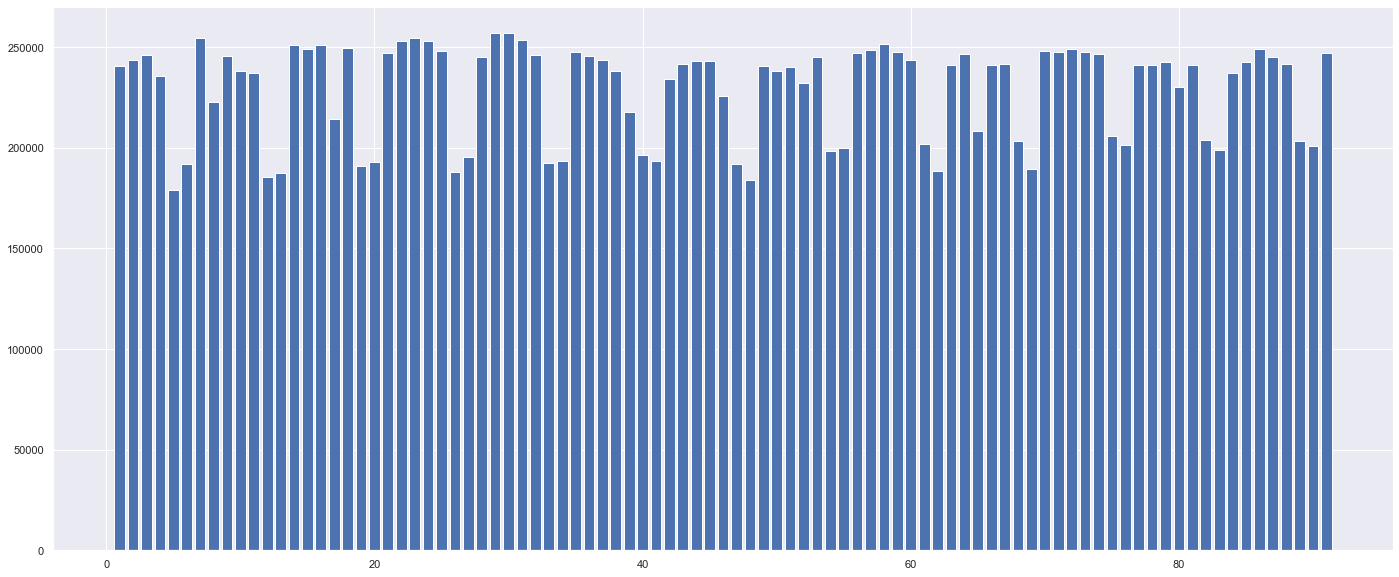

In [19]:
days_of_doc = cards_groupped['date'].mean().astype(int)
days_doc = days_of_doc.value_counts().reset_index()
plt.figure(figsize=(24, 10))
plt.bar(days_doc['index'], days_doc['date'])

<BarContainer object of 91 artists>

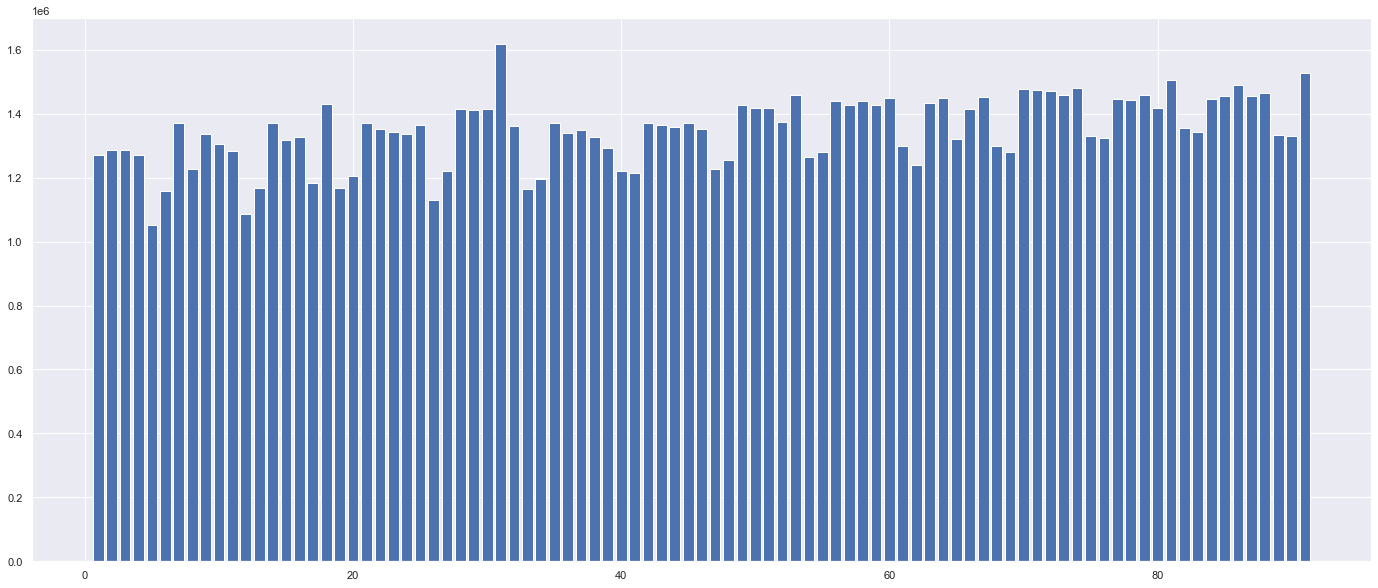

In [14]:
days = gs.date.value_counts(sort=False).reset_index()
plt.figure(figsize=(24, 10))
plt.bar(days['index'], days['date'])

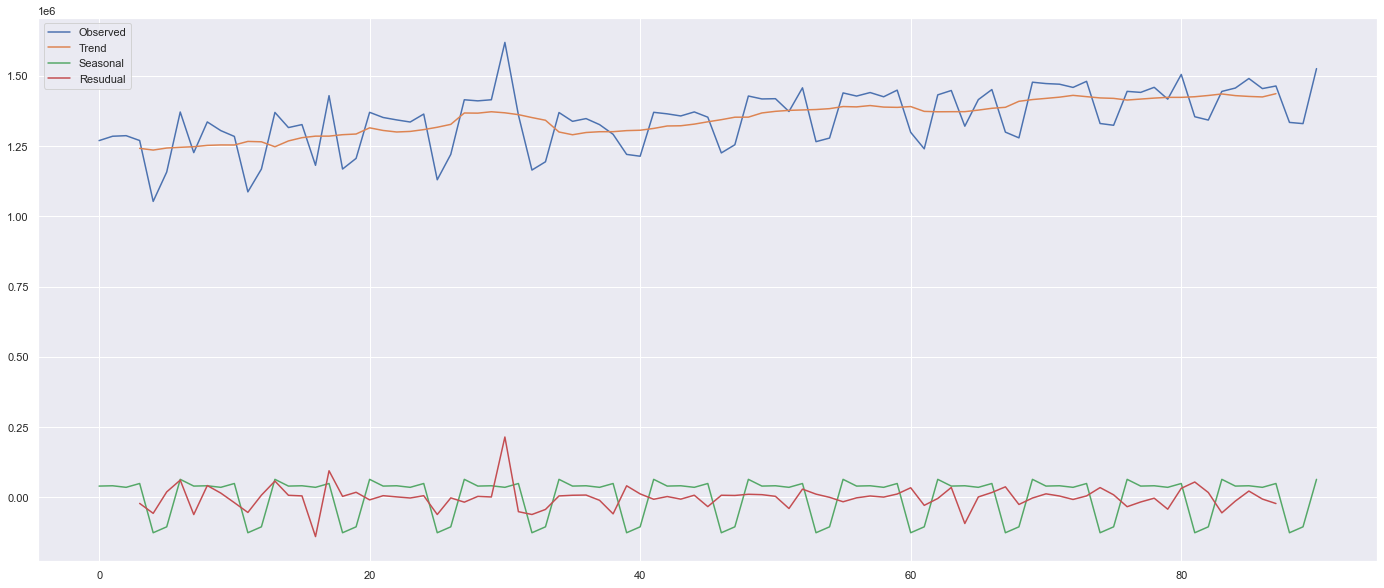

In [20]:
series = days['date']
result = seasonal_decompose(series, model='additive', period=7)
plt.figure(figsize=(24, 10))
plt.plot(result.observed, label='Observed')
plt.plot(result.trend, label='Trend')
plt.plot(result.seasonal, label='Seasonal')
plt.plot(result.resid, label='Resudual')
plt.legend()

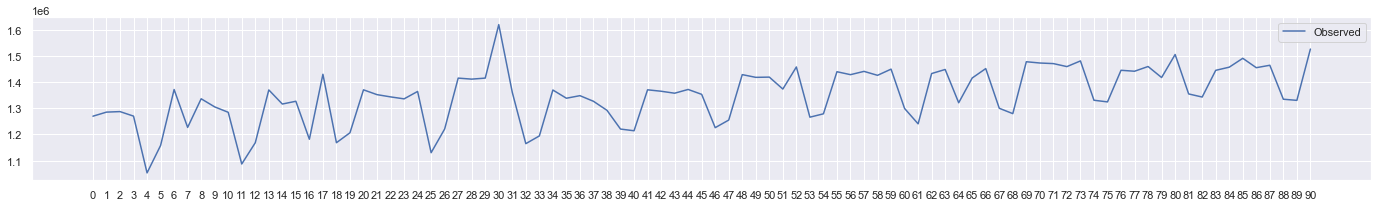

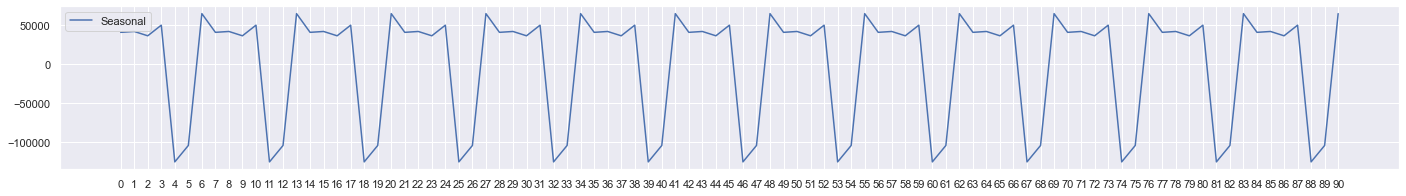

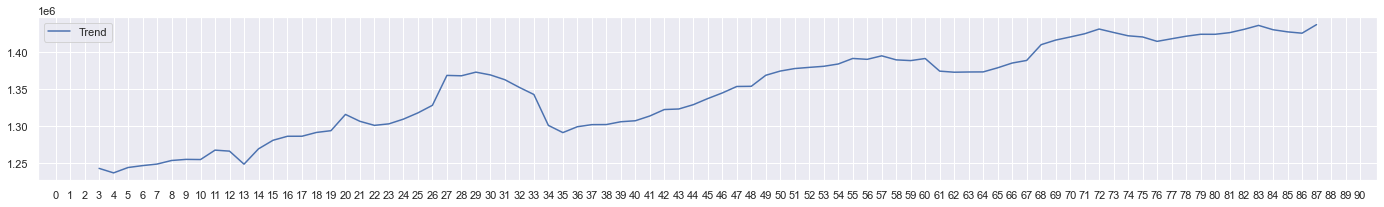

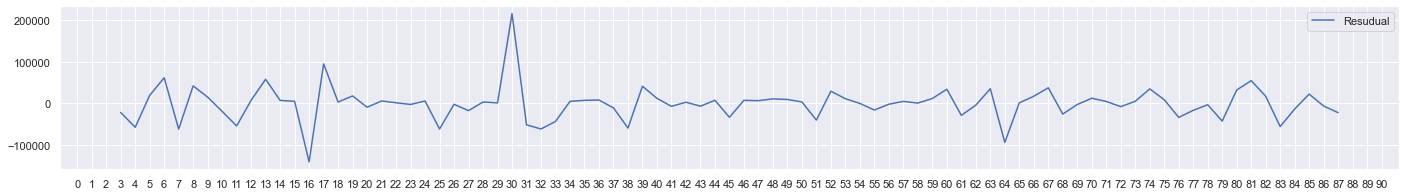

In [22]:
series = days['date']
result = seasonal_decompose(series, model='additive', period=7)
index = result.observed.index
plt.figure(figsize=(24, 3))
plt.plot(result.observed, label='Observed')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result.seasonal, label='Seasonal')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result.trend, label='Trend')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result.resid, label='Resudual')
plt.xticks(index)
plt.legend()

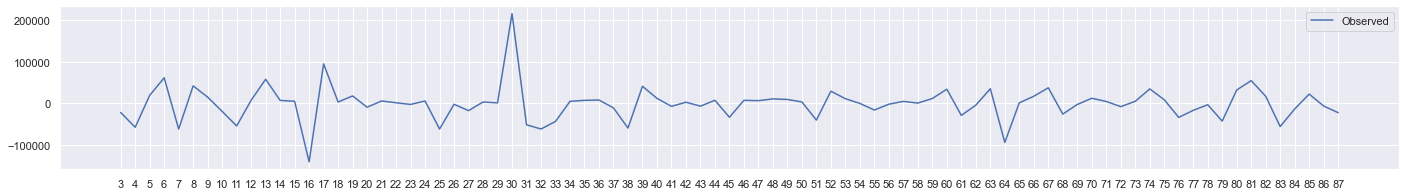

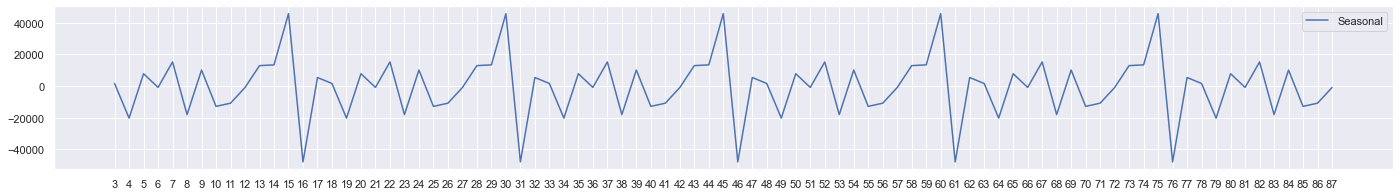

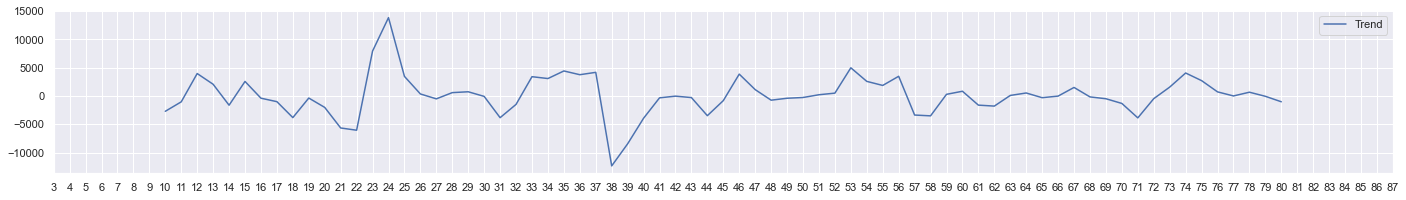

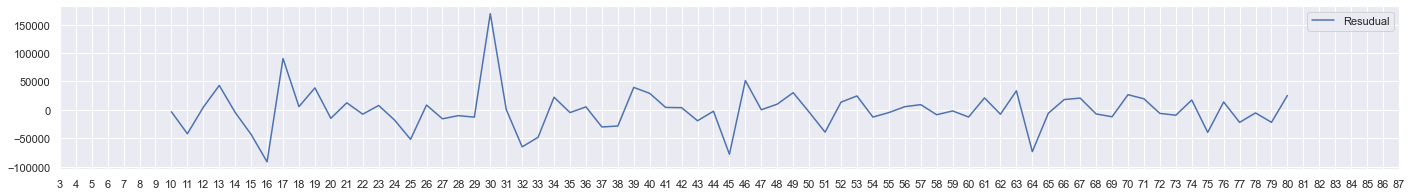

In [23]:
result2 = seasonal_decompose(result.resid.dropna(), model='additive', period=15)
index = result2.observed.index
plt.figure(figsize=(24, 3))
plt.plot(result2.observed, label='Observed')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result2.seasonal, label='Seasonal')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result2.trend, label='Trend')
plt.xticks(index)
plt.legend()
plt.figure(figsize=(24, 3))
plt.plot(result2.resid, label='Resudual')
plt.xticks(index)
plt.legend()

I don't see any significant half-months periodicity related to the shopping grows around the wage taking days. There are rather periodicity related to the weekday. At weekend number of shoppings significantly drops.

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
1. Average purchase sum - The customers that usually spend the same amount of money 
1. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

In [3]:
gs = pd.read_csv(data_path / 'all_groups.csv', usecols=['date', 'id_doc', 'id_card', 'sum', 'is_green', 'id_tov'], dtype=dict(is_green=bool))

In [4]:
gs.set_index(['id_card', 'date'], inplace=True)
gs.sort_index(inplace=True)
gs_no_id = gs.reset_index()
# gs.reset_index(inplace=True)

### Frequent buyers

In [5]:
id_card_date = gs_no_id[['id_card', 'date']].drop_duplicates()
id_card_date.reset_index(inplace=True, drop=True)

In [6]:
presence = np.zeros((id_card_date.id_card.max() + 1, 91))
presence[id_card_date.values[:, 0], id_card_date.values[:, 1] - 1] = 1

Text(0.5, 0, 'Number of days when the customer bought something')

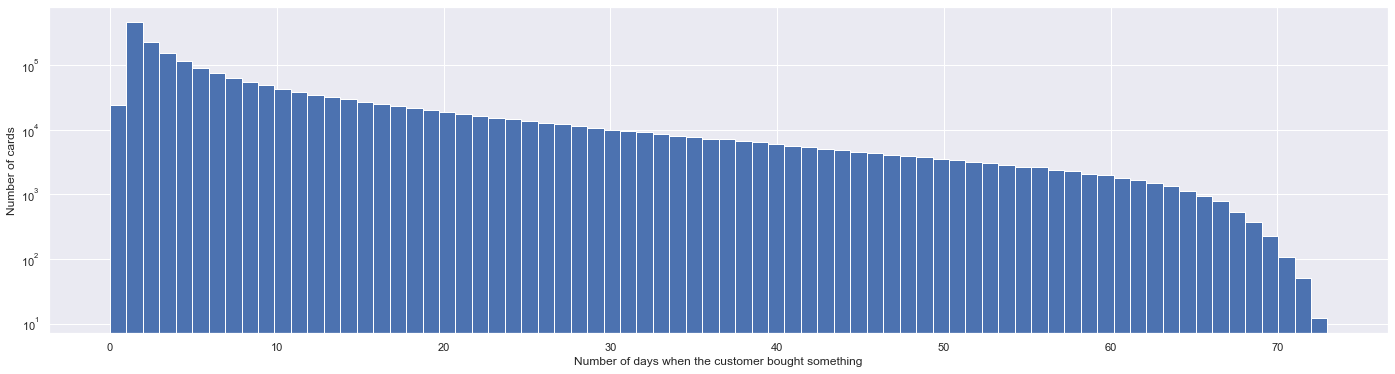

In [7]:
plt.figure(figsize=(24, 6))
presence_sum = presence.sum(axis=1)
_ = plt.hist(presence_sum, bins=74)
plt.yscale('log')
plt.ylabel('Number of cards')
plt.xlabel('Number of days when the customer bought something')

We can consider customers:
1. with number of visited days more than 45 (91 days in three months / 2) as a **daily buyers**;
1. with number of visited days more than 12 but less than 46 as a **weekly buyers**;
1. with number of visited days more than 2 but less than 13 as a **monthly buyers**;
1. with number of visited days less than 3 as a **random visiters**;

In [39]:
daily = (presence_sum > 45)
weekly = ((presence_sum < 46) & (presence_sum > 12))
monthly = ((presence_sum < 13) & (presence_sum > 2))
random = ((presence_sum < 3) & (presence_sum > 0))
print(f'Daily buyers: {daily.sum()}\nWeekly buyers: {weekly.sum()}\nMonthly buyers: {monthly.sum()}\nRandom buyers: {random.sum()}')

Daily buyers: 56701
Weekly buyers: 438438
Monthly buyers: 722896
Random buyers: 701334


### Average purchase sum

In [85]:
fgh = gs_no_id.groupby(['id_card', 'date'])
purchase_sum = fgh['sum'].sum()
purchase_sum_groupped = purchase_sum.reset_index().groupby('id_card')['sum']
id_card_std = purchase_sum_groupped.std().fillna(0)
id_card_mean = purchase_sum_groupped.mean()
conds = (daily[id_card_std.index] | weekly[id_card_std.index] | monthly[id_card_std.index]) & (id_card_mean > 0) & (id_card_std != 0)
id_card_mean = id_card_mean[conds]
id_card_std = id_card_std[conds]

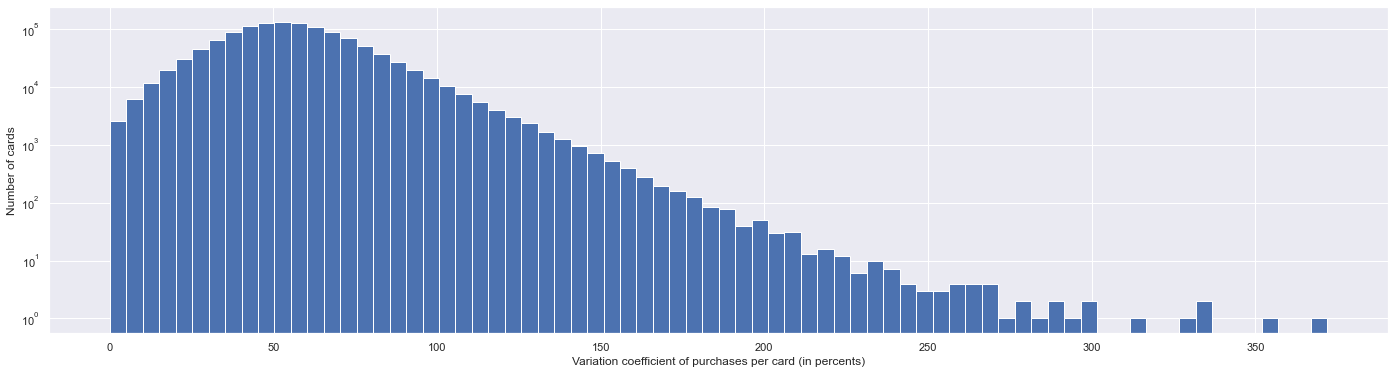

In [90]:
plt.figure(figsize=(24, 6))
plt.yscale('log')
plt.ylabel('Number of cards')
plt.xlabel('Variation coefficient of purchases per card (in percents)')
_ = plt.hist(100 * id_card_std / id_card_mean, bins=74)

We can consider people that are not random visiters and has variation coefficient less than 20% as **buyers that usually spend the same amount of money**. 

In [93]:
print('Buyers that usually spend the same amount of money:', (id_card_std / id_card_mean < 0.2).sum())

Buyers that usually spend the same amount of money: 39184


### Usual cart

In [4]:
gs = pd.read_csv(data_path / 'all_groups.csv', usecols=['date', 'id_card', 'id_tov'])

In [5]:
p_g = pd.read_csv(data_path / 'product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.set_index('id_tov').id_group

id_tov
52       10004
75       10004
77       10004
143      10004
151      10004
         ...  
40762    52194
40763    52194
40764    52194
40765    52194
34611    52406
Name: id_group, Length: 5650, dtype: int64

In [7]:
new_gs = gs.merge(p_g[['id_tov', 'id_group']], on='id_tov')
new_gs.drop(columns=['id_tov'], inplace=True)
new_gs.set_index(['id_card', 'date'], inplace=True)
new_gs.sort_index(inplace=True)
gs = new_gs.reset_index()

In [12]:
gs

,id_card,date,id_group
0,0,7,10155
1,0,7,10038
2,0,7,10374
3,0,7,10032
4,0,9,10091
...,...,...,...
120300799,1944074,87,10037
120300800,1944074,87,10098
120300801,1944074,87,10192
120300802,1944074,88,10049


In [26]:
mapping = p_g.id_group.drop_duplicates().reset_index(drop=True).reset_index(drop=False).set_index('id_group')

In [117]:
p_g.id_group.max()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты
...,...,...,...
5645,40762,52194,Подарки и сувениры
5646,40763,52194,Подарки и сувениры
5647,40764,52194,Подарки и сувениры
5648,40765,52194,Подарки и сувениры


In [ ]:
def GbI(x):
    z = np.zeros([len_map], dtype=bool)
    z[x] = True
    return z

def spl(a):
    return np.split(a[:,1:], np.unique(a[:, 0], return_index=True, axis=0)[1][1:])

In [128]:
mapp = np.zeros(p_g.id_group.max() + 1, dtype=int)
mapp[mapping.reset_index().id_group.values] = mapping.reset_index().index.values
len_map = len(mapping)

In [239]:
groups = new_gs.iloc[:10000]

In [242]:
ds = new_gs.reset_index().values
# preprocessed = np.vstack([np.stack([GbI(mapp[j.flatten()]) for j in spl(i)]) for i in spl(ds)])

In [ ]:
preprocessed = np.vstack([np.stack([GbI(mapp[j.flatten()]) for j in spl(i)]) for i in spl(ds)])